## Installation

###  Installing Anaconda navigator to set up jupyter notebook environment (you can skip this if you already can run jupyter notebooks in an environment)

- A recommended short 5 min youtube video on setting up jupyter notebook can be found [here](https://www.youtube.com/watch?v=Gq167zHsuA0),(https://www.youtube.com/watch?v=Gq167zHsuA0) \
  The main steps: 
    - Install [Anaconda navigator](https://www.anaconda.com/download/success), select a graphical installer
    - Create an environemnt. `Environments` on left menu-> `create` option at the bottom -> name the new environemnt and `create`. Python version should be 3.9 or more recent (recommended is 3.9). You can find the documentation [here](https://docs.anaconda.com/navigator/getting-started/) . 
    - Install jupyter notebooks in the environment. `Home` on the left menu -> check if you are on the new environment, the name should be selected on the dropdown menu after `on` on the top of the page -> Click on `install` under the jupyter notebooks icon.
    - Click on `launch` under the  jupyter notebooks icon and navigate to this workshop notebook and proceed to install the packages.
    


### Installing scvi-tools and some other packages 

In [34]:
# Only need to run this once, installs the necessary packages
import sys
!{sys.executable} -m pip install scanpy scvi-tools seaborn scikit-misc igraph leidenalg
# Typically, it's better practice to perform conda installations when using conda environments as we are,
# but if we don't have too many dependencies we get away with pip installations 

You will need to restart the kernel after installing the packages (Kernel (toolbar/header bar) -> restart kernel )

# Introduction to scvi-tools

Adapted from https://docs.scvi-tools.org/en/stable/tutorials/notebooks/quick_start/api_overview.html

In this workshop we will introduce anndata object, perform simple QC, train an scVI model with the subsampled heart atlas, inspect scVI batch correction and perform clustering analysis.

$\otimes$  indicates advanced/extra topics


In [1]:
import warnings
warnings.filterwarnings('ignore') # suppresses warning messages 

# Loading ncessary modules
import os
import tempfile
import scanpy as sc
import scvi
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from IPython.display import display

In [2]:
# Setting random seed to 

scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

[rank: 0] Global seed set to 0


Last run with scvi-tools version: 1.0.0b0


In [3]:
# Ensures high precisison for torch operations
torch.set_float32_matmul_precision("high")

# Creates temporary folder to save the data
save_dir = tempfile.TemporaryDirectory()

# presets certain figure parameters 
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

## Loading and preparing data

Let us first load a subsampled version of the heart cell atlas dataset described in Litviňuková et al. (2020). scvi-tools has many "built-in" datasets as well as support for loading arbitrary `.csv`, `.loom`, and `.h5ad` (AnnData) files. The scvi-tools documentation (https://docs.scvi-tools.org/en/stable/index.html) is well written and extensive.  

### Download and load the data

In [4]:
# download the data to the temporary directory
adata = scvi.data.heart_cell_atlas_subsampled(save_path=save_dir.name)
adata

INFO     Downloading file at /tmp/tmpibptoc_i/hca_subsampled_20k.h5ad                                              
Downloading...: 100%|██████████| 65714/65714.0 [00:00<00:00, 352871.62it/s]


AnnData object with n_obs × n_vars = 18641 × 26662
    obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'cell_states', 'Used'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45', 'n_counts'
    uns: 'cell_type_colors'

 ### The data is loaded as an anndata (annotated data) object.
 
 The figure below illustrated the structure of the anndata object. In essence it is a concise way fo saving the data matrix (singel-cell RNA-seq counts) along with the information about the variables (genes) and observations (cells)

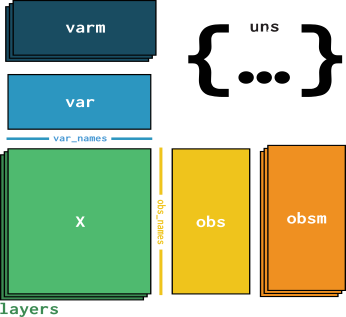

 - Information about the genes (variables) are found in the `var` slot of the object (accessed via `.var`). The `varm` slot is a multidimensional verison of `var`.

 - Information about the cells (observations) are found in the `obs` slot of the object (accessed via `.obs`). The `obsm` slot is a multidimensional verison of `obsm`.

 - Information with the same dimensionalities as the data is stored in `layers`, this includes transformed/normlaized data that we compute. 

 - Other unstructured annotations are found in the `uns` slot (via `.uns`), including information about dimensionality reduction or other calculations that have been performed on the object.


## Acessing data and information from `anndata` object

In [5]:
print('Data matrix of counts')
print(adata.X.todense() )
print(' \n Cell/observations information')
display(adata.obs)
print('\n Genes/variables information')
display(adata.var) 

Data matrix of counts
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
 
 Cell/observations information


,NRP,age_group,cell_source,cell_type,donor,gender,n_counts,n_genes,percent_mito,percent_ribo,region,sample,scrublet_score,source,type,version,cell_states,Used
AACTCCCCACGAGAGT-1-HCAHeart7844001,Yes,65-70,Sanger-CD45,Myeloid,D6,Male,1420.0,738,0.054930,0.064789,LA,HCAHeart7844001,0.113475,CD45+,DCD,V2,LYVE1+MØ1,Yes
ATAACGCAGAGCTGGT-1-HCAHeart7829979,No,70-75,Sanger-Nuclei,Ventricular_Cardiomyocyte,D4,Female,844.0,505,0.001185,0.001185,RV,HCAHeart7829979,0.085546,Nuclei,DCD,V2,vCM1,Yes
GTCAAGTCATGCCACG-1-HCAHeart7702879,Yes,60-65,Sanger-Nuclei,Fibroblast,D2,Male,1491.0,862,0.000000,0.005366,RA,HCAHeart7702879,0.197861,Nuclei,DCD,V2,FB2,Yes
GGTGATTCAAATGAGT-1-HCAHeart8102858,Yes,60-65,Sanger-CD45,Endothelial,D11,Female,2167.0,1115,0.064144,0.027227,LA,HCAHeart8102858,0.113475,CD45+,DCD,V3,EC10_CMC-like,Yes
AGAGAATTCTTAGCAG-1-HCAHeart8102863,Yes,60-65,Sanger-Cells,Endothelial,D11,Female,7334.0,2505,0.093537,0.040496,RA,HCAHeart8102863,0.132150,Cells,DCD,V3,EC5_art,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CGTCAGGCAAGGCTCC-1-HCAHeart7985087,No,55-60,Sanger-Nuclei,Ventricular_Cardiomyocyte,D3,Male,4478.0,2243,0.002233,0.001340,RV,HCAHeart7985087,0.185751,Nuclei,DBD,V2,vCM1,Yes
AGTCACAAGACGAGCT-1-H0035_RV,No,45-50,Harvard-Nuclei,Pericytes,H7,Female,967.0,630,0.002068,0.004137,RV,H0035_RV,0.081779,Nuclei,DBD,V3,PC1_vent,Yes
GGTGAAGGTTCCACAA-1-HCAHeart7844001,Yes,65-70,Sanger-CD45,Lymphoid,D6,Male,1599.0,619,0.041901,0.155722,LA,HCAHeart7844001,0.074830,CD45+,DCD,V2,CD4+T_tem,Yes
CAGCTAAGTACAGACG-1-HCAHeart7702876,Yes,60-65,Sanger-Nuclei,Atrial_Cardiomyocyte,D2,Male,3715.0,1523,0.000269,0.002423,LA,HCAHeart7702876,0.048649,Nuclei,DCD,V2,aCM3,Yes



 Genes/variables information


,gene_ids-Harvard-Nuclei,feature_types-Harvard-Nuclei,gene_ids-Sanger-Nuclei,feature_types-Sanger-Nuclei,gene_ids-Sanger-Cells,feature_types-Sanger-Cells,gene_ids-Sanger-CD45,feature_types-Sanger-CD45,n_counts
AL627309.1,ENSG00000238009,Gene Expression,ENSG00000238009,0,ENSG00000238009,0,ENSG00000238009,0,249.0
AC114498.1,ENSG00000235146,Gene Expression,ENSG00000235146,0,ENSG00000235146,0,ENSG00000235146,0,28.0
AL669831.2,ENSG00000229905,Gene Expression,ENSG00000229905,0,ENSG00000229905,0,ENSG00000229905,0,3.0
AL669831.5,ENSG00000237491,Gene Expression,ENSG00000237491,0,ENSG00000237491,0,ENSG00000237491,0,1342.0
FAM87B,ENSG00000177757,Gene Expression,ENSG00000177757,0,ENSG00000177757,0,ENSG00000177757,0,15.0
...,...,...,...,...,...,...,...,...,...
AC007325.2,ENSG00000277196,Gene Expression,ENSG00000277196,0,ENSG00000277196,0,ENSG00000277196,0,68.0
BX072566.1,ENSG00000277630,Gene Expression,ENSG00000277630,0,ENSG00000277630,0,ENSG00000277630,0,4.0
AL354822.1,ENSG00000278384,Gene Expression,ENSG00000278384,0,ENSG00000278384,0,ENSG00000278384,0,476.0
AC004556.1,ENSG00000276345,Gene Expression,ENSG00000276345,0,ENSG00000276345,0,ENSG00000276345,0,151.0


Lets inspect the different cell type annotations present

In [6]:
# Listing out the different cell type annotations 
list_of_sell_types  = adata.obs['cell_type'].cat.categories.tolist() 
print('List of cell types:', list_of_sell_types)

List of cell types: ['Adipocytes', 'Atrial_Cardiomyocyte', 'Endothelial', 'Fibroblast', 'Lymphoid', 'Mesothelial', 'Myeloid', 'Neuronal', 'Pericytes', 'Smooth_muscle_cells', 'Ventricular_Cardiomyocyte']


<br>



### <font color='blue'>[Q]</font>   List the various age groups of the cells. 

In [1]:
# Solution


## Pre-processing 

### Filtering uninformative genes

Genes that have a minimum count of $3$ are removed as they contain not information.

In [8]:
sc.pp.filter_genes(adata, min_counts=3)
adata # We see that the number of gene (n_vars) has decreased

AnnData object with n_obs × n_vars = 18641 × 26469
    obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'cell_states', 'Used'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45', 'n_counts'
    uns: 'cell_type_colors'

### Normalising the data 

Normalisation aims to remove the influence of technical effects in the expression profiles of cells. One major source of technical differences in scRNA-seq is library size (the sum of counts across all genes for a cell), which can be normalised using scanpy's function [`.normalize_total()`](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.normalize_total.html).

In [9]:
adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`

We perform feature selection, to reduce the number of features (genes in this case) used as input to the scvi-tools model. Higly variable genes are a measure to identify genes that vary in terms of gene expression across all cells present in the data set. We recommend anywhere from 1,000 to 10,000 HVGs, but it will be context-dependent.  
$\otimes$  Discussions based on the selection of highly varibale genes can be found in [Basics of Single-Cell Analysis with Bioconductor](https://bioconductor.org/books/3.15/OSCA.basic/feature-selection.html#hvg-selection).

In [10]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="cell_source",
)

 Now it's time to run `setup_anndata()`, which alerts scvi-tools to the locations of various matrices inside the anndata. It's important to run this function with the correct arguments so scvi-tools is notified that your dataset has batches, annotations, etc. For example, if batches are registered with scvi-tools, the subsequent model will correct for batch effects. See the full documentation for details.

In this dataset, there is a "cell_source" categorical covariate, and within each "cell_source", multiple "donors", "gender" and "age_group". There are also two continuous covariates we'd like to correct for: "percent_mito" and "percent_ribo". These covariates can be registered using the `categorical_covariate_keys` argument. If you only have one categorical covariate, you can also use the `batch_key` argument instead.

In [11]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["cell_source", "donor"],
    continuous_covariate_keys=["percent_mito", "percent_ribo"],
)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Creating and training a model
We create an scVI model with the adata object

In [12]:
model = scvi.model.SCVI(adata)

We can see an overview of the model by printing it

In [13]:
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Not Trained
Model's adata is minified?: False

The number of epochs should be best $400$ or more for the scVI model, it's good practise to inspect the loss (ELBO) of the model to inspect if it's converged or not.

$\otimes$ scVI inference uses a concept of KL warmup (monotonic annealing scheduling) to $400$ epochs, thus it's better practise to use more than $400$ epochs. A discussion on this concept can be found in [Training trick for VAE](https://medium.com/@chengjing/a-must-have-training-trick-for-vae-variational-autoencoder-d28ff53b0023).

In [14]:
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


<generator object Module.parameters at 0x14812d04af80>
Epoch 400/400: 100%|██████████| 400/400 [05:32<00:00,  1.20it/s, v_num=1, train_loss_step=288, train_loss_epoch=284]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [05:32<00:00,  1.20it/s, v_num=1, train_loss_step=288, train_loss_epoch=284]


Load pre-trained model if the training process is too time consuming

In [35]:
model = scvi.model.SCVI.load("scvi_model_heart_cell_atlas_subsampled", adata=adata)

INFO     File scvi_model_heart_cell_atlas_subsampled/model.pt already downloaded                                   


We can plot the loss values to inspect convergence

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


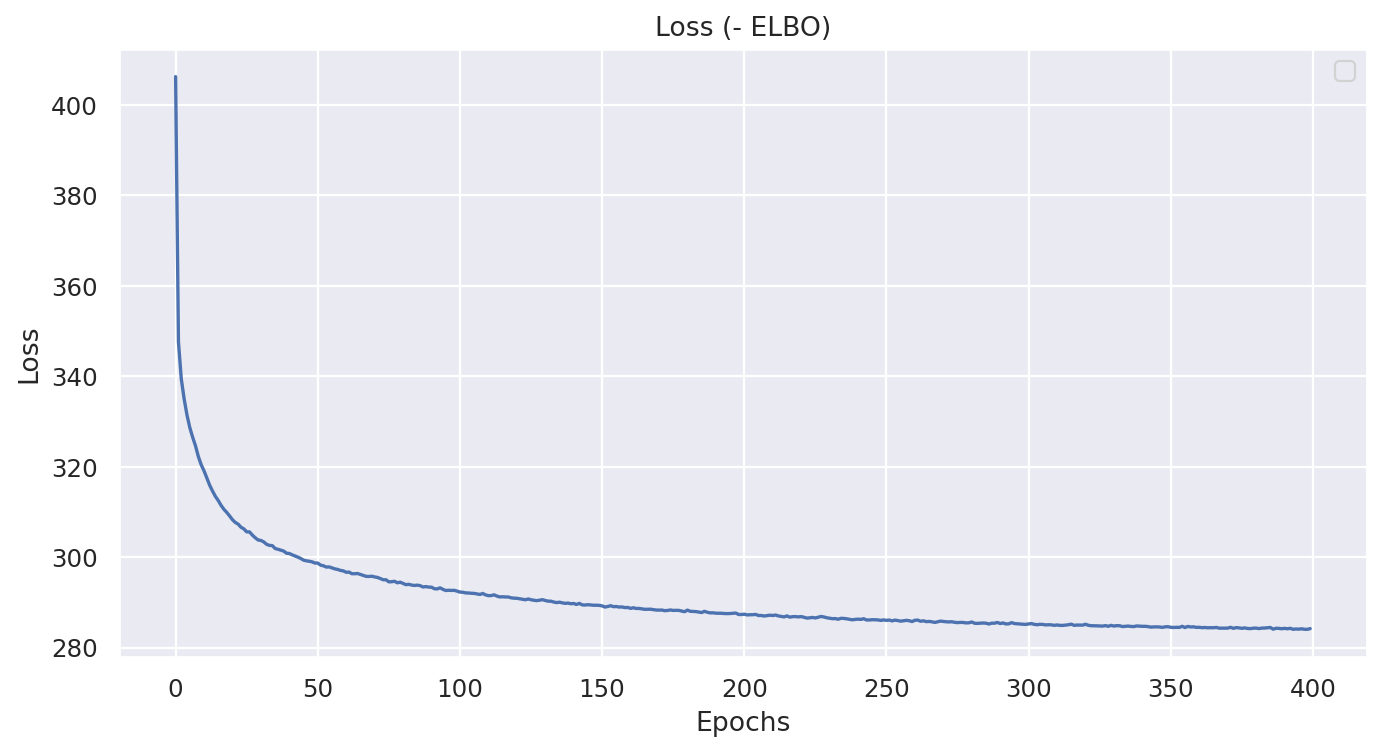

In [37]:
elbo_train = model.history['elbo_train']

plt.figure(figsize =(10,5))
plt.plot(elbo_train)
plt.title('Loss (- ELBO)')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

## Saving and loading the scVI model

Saving saving the neural network weights of the model.

In [53]:
model_dir = os.path.join(save_dir.name, "scvi_model")
model.save(model_dir, overwrite=True) # overwrites = true, saves the model if already present 

In [18]:
model = scvi.model.SCVI.load(model_dir, adata=adata)

INFO     File scvi_model/model.pt already downloaded                                                               


### Obtaining model outputs

It's often useful to store the outputs of scvi-tools back into the original anndata, as it permits interoperability with Scanpy.

In [38]:
SCVI_LATENT_KEY = "X_scVI"
latent = model.get_latent_representation()
adata.obsm[SCVI_LATENT_KEY] = latent
latent.shape

(18641, 10)

In [39]:
denoised = model.get_normalized_expression(adata, library_size=1e4) # This by default has batch effects, but can be used for batch correction 
denoised.iloc[:5, :5]

,ISG15,TNFRSF18,VWA1,HES5,SPSB1
AACTCCCCACGAGAGT-1-HCAHeart7844001,10.753584,0.136991,0.360322,0.117154,0.841199
ATAACGCAGAGCTGGT-1-HCAHeart7829979,1.758288,0.001705,0.153933,0.001246,3.196883
GTCAAGTCATGCCACG-1-HCAHeart7702879,0.787787,0.219748,1.439142,0.016987,1.313568
GGTGATTCAAATGAGT-1-HCAHeart8102858,16.396879,0.017535,6.300491,0.367128,0.835881
AGAGAATTCTTAGCAG-1-HCAHeart8102863,6.337528,0.260359,6.558031,0.530781,2.966028


<br>

### <font color='blue'>[Q]</font>    Save the normalised expression as a adata object layer called "scvi_normalized"

In [40]:
# Solution


## Downstream analysis with Scanpy

### Visualisation with batch correction

We use UMAP to *qualitatively* assess our low-dimension embeddings of cells. 

The embedding created by the scVI model can be treated as a replacement for PCA embeddings. 



In [41]:
# run PCA then generate UMAP plots
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)


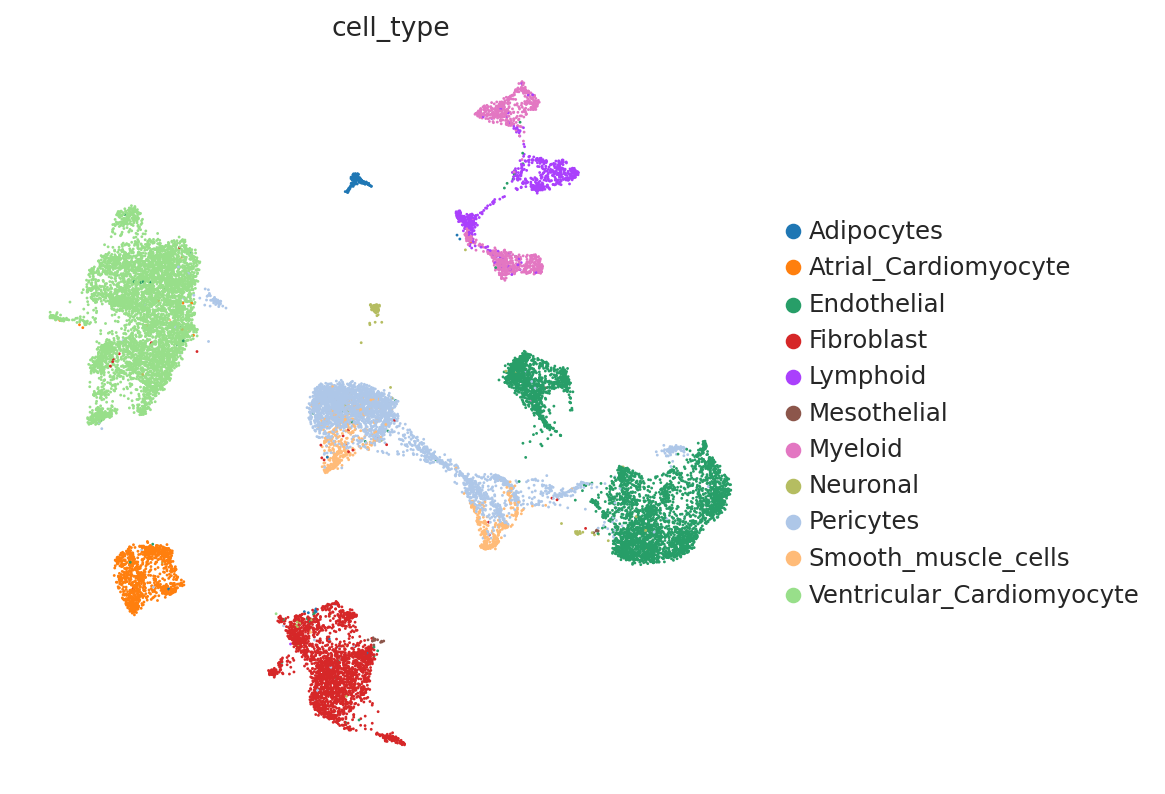

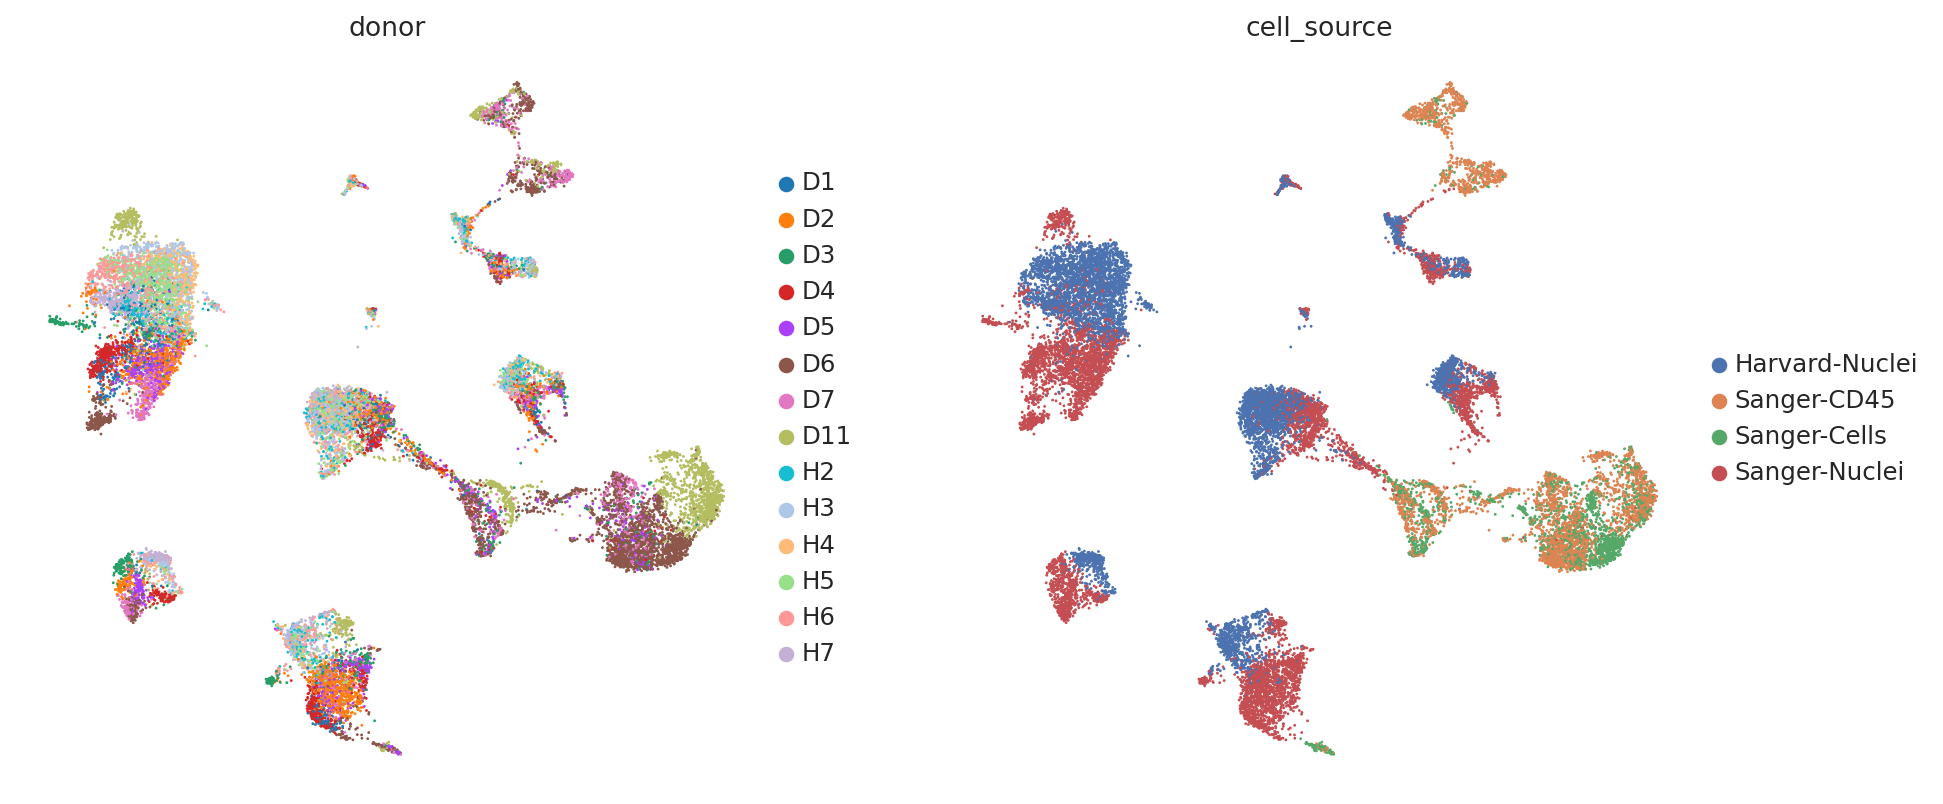

In [42]:
sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["donor", "cell_source"],
    ncols=2,
    frameon=False,
)

### <font color='blue'>[Q]</font>   What do we observe in the UMAP plots in relation with batch effects? 

Solution:


### Visualisation without batch correction (scVI)

<br>

### <font color='blue'>[Q]</font>   Instead of using PCA embedding, use the scVI embeddings to create the UMAPS. Hint: use `use_rep` argument for `neighbors`.

In [43]:
# solution


<br>


### <font color='blue'>[Q]</font>   What difference do we observe when comparing the PCA and scVI embedded UMAPS?

Solution:


## Clustering on the scVI embeddings

In [45]:
# Using the neighbors computed with scVI embeddings 
SCVI_CLUSTERS_KEY = "leiden_scVI"
sc.tl.leiden(adata, key_added=SCVI_CLUSTERS_KEY, resolution=0.5)

The labels simply represent different clusters of cells identified through analysis, with each cluster grouping cells that share similar gene expression profiles. These labels themselves do not imply biological significance and require further investigation to assign specific cell types or functions.

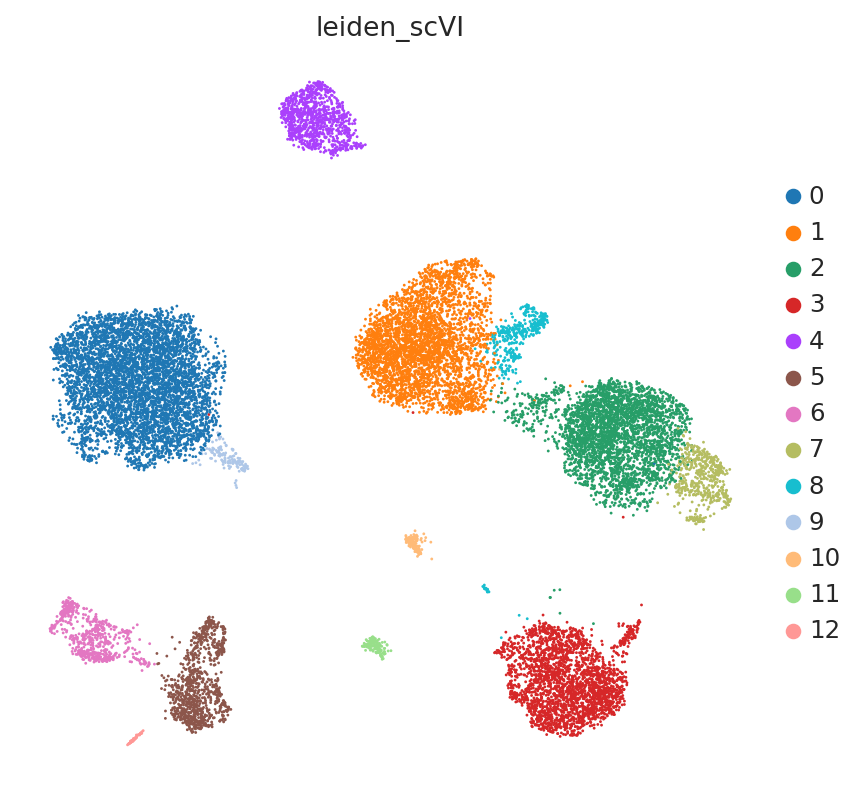

In [46]:
sc.pl.umap(
    adata,
    color=[SCVI_CLUSTERS_KEY],
    frameon=False
)

In [47]:
de_df = model.differential_expression(
    groupby="leiden_scVI"
)
de_df.head()

DE...: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
C15orf41,0.9968,0.0032,5.741396,0.011220,0.000706,0.0,0.25,5.150204,4.885277,2.289322,...,3.972142,0.121640,0.844114,0.076642,105.554642,6.085229,True,0 vs Rest,0,Rest
FYB2,0.9962,0.0038,5.568944,0.003197,0.000192,0.0,0.25,6.241058,5.754079,3.147415,...,1.215224,0.027313,0.540164,0.020672,30.396643,1.106784,True,0 vs Rest,0,Rest
LINC02506,0.9950,0.0050,5.293303,0.001085,0.000061,0.0,0.25,7.566066,7.469976,3.980938,...,0.246518,0.008806,0.088151,0.005224,6.241395,0.342665,True,0 vs Rest,0,Rest
LINC02248,0.9948,0.0052,5.253881,0.002358,0.000734,0.0,0.25,6.464097,6.060293,4.276574,...,0.686315,0.336341,0.313108,0.073657,16.870489,9.433337,True,0 vs Rest,0,Rest
GALNT17,0.9942,0.0058,5.144079,0.008402,0.000506,0.0,0.25,6.367106,5.983205,3.329613,...,2.925214,0.077686,0.752147,0.035821,77.631264,3.025079,True,0 vs Rest,0,Rest


In [51]:
markers = {} # Dictionary to save the markers
cats = adata.obs['leiden_scVI'].cat.categories
for c in cats:
    cid = f"{c} vs Rest"
    cell_type_df = de_df.loc[de_df.comparison == cid]

    cell_type_df = cell_type_df[cell_type_df.lfc_mean > 0] 
    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 3] 
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.1] 
    
    markers[c] = cell_type_df.index.tolist()[:10]
print('Marker genes for the different clusters')
print(markers)

Marker genes for the different clusters
{'0': ['C15orf41', 'FYB2', 'LINC02248', 'GALNT17', 'LINC02552', 'BDNF', 'RYR2', 'SORBS2', 'CDH2', 'MLIP-AS1'], '1': ['SLC9A3R2', 'EGFL7', 'CLDN5', 'FCN3', 'SOX17', 'VWF', 'CXCL2', 'IFI27', 'F8', 'PECAM1'], '2': ['HIGD1B', 'CPE', 'ISYNA1', 'GPAT2', 'RGS5', 'NOTCH3', 'AGT', 'KCNJ8', 'STEAP4', 'KCNE4'], '3': ['CDH19', 'NEGR1', 'MEG3', 'MGST1', 'BICC1', 'FBN1', 'GLIS3', 'NLGN4X', 'C3', 'COL6A3'], '4': ['MYL7', 'SYNPR', 'MYL4', 'KCNJ3', 'MYH6', 'ZNF385B', 'OTOGL', 'LINC02248', 'CADPS', 'NPPA'], '5': ['MS4A6A', 'SPI1', 'CTSB', 'FCGR2A', 'MS4A4A', 'CD163', 'C1QB', 'VSIG4', 'HMOX1', 'MARCO'], '6': ['KLRB1', 'CD69', 'CD2', 'TRBC1', 'GZMA', 'GZMK', 'RAC2', 'GZMH', 'CD3D', 'CCL5'], '7': ['MYH11', 'TAGLN', 'WFDC1', 'ACTG2', 'ID4', 'ACTA2', 'MYLK', 'KCNMB1', 'PHLDA2', 'NET1'], '8': ['PLVAP', 'ACKR1', 'PTGS1', 'PKHD1L1', 'SLCO2A1', 'POSTN', 'SELP', 'ADGRG6', 'MPZL2', 'CSF3'], '9': ['XIRP2', 'FLNC-AS1', 'C4orf54', 'ATP6V1FNB', 'KCP', 'FLNC', 'AC078980.1', 'LINC

### Using large language models (LLMs) for cell type annotations is an emerging research topic
$\otimes$ [Geneformer](https://www.nature.com/articles/s41586-023-06139-9) and [scGPT](https://www.nature.com/articles/s41592-024-02201-0#Sec14) are two such model. They are pre-trained on databases single-cell transcriptomes which can be used for other downstrean analysis.

Lets inspect if Chatgpt can determine the cell type based on the cluster markers

Lets use the following promp to Chatgpt along with the dictionary of markers to see if it can infer the correct cell types
>  Name the cell types from the differentially expressed found after clustering from scRNA-seq. The data is from heart tissue. list the cell types corresponding to the clusters and explain briefly why so. Also provide a dictionary of the annotated cell type.
{'0': ['C15orf41', 'FYB2', 'LINC02248', 'GALNT17', 'LINC02552', 'BDNF', 'RYR2', 'SORBS2', 'CDH2', 'MLIP-AS1'], '1': ['SLC9A3R2', 'EGFL7', 'CLDN5', 'FCN3', 'SOX17', 'VWF', 'CXCL2', 'IFI27', 'F8', 'PECAM1'], '2': ['HIGD1B', 'CPE', 'ISYNA1', 'GPAT2', 'RGS5', 'NOTCH3', 'AGT', 'KCNJ8', 'STEAP4', 'KCNE4'], '3': ['CDH19', 'NEGR1', 'MEG3', 'MGST1', 'BICC1', 'FBN1', 'GLIS3', 'NLGN4X', 'C3', 'COL6A3'], '4': ['MYL7', 'SYNPR', 'MYL4', 'KCNJ3', 'MYH6', 'ZNF385B', 'OTOGL', 'LINC02248', 'CADPS', 'NPPA'], '5': ['MS4A6A', 'SPI1', 'CTSB', 'FCGR2A', 'MS4A4A', 'CD163', 'C1QB', 'VSIG4', 'HMOX1', 'MARCO'], '6': ['KLRB1', 'CD69', 'CD2', 'TRBC1', 'GZMA', 'GZMK', 'RAC2', 'GZMH', 'CD3D', 'CCL5'], '7': ['MYH11', 'TAGLN', 'WFDC1', 'ACTG2', 'ID4', 'ACTA2', 'MYLK', 'KCNMB1', 'PHLDA2', 'NET1'], '8': ['PLVAP', 'ACKR1', 'PTGS1', 'PKHD1L1', 'SLCO2A1', 'POSTN', 'SELP', 'ADGRG6', 'MPZL2', 'CSF3'], '9': ['XIRP2', 'FLNC-AS1', 'C4orf54', 'ATP6V1FNB', 'KCP', 'FLNC', 'AC078980.1', 'LINC01411', 'DLG1', 'AC009318.1'], '10': ['GPM6B', 'SEMA3B', 'CHL1', 'L1CAM', 'PLP1', 'NRXN1', 'ERBB3', 'LGI4', 'PTPRZ1', 'XKR4'], '11': ['GPAM', 'SLC19A3', 'ARHGAP20', 'CIDEC', 'PLIN1', 'GPD1', 'PNPLA3', 'LGALS12', 'ACSL1', 'ADIPOQ'], '12': ['HPGDS', 'KIT', 'CPA3', 'NTM', 'SLC24A3', 'MS4A4E', 'AC092979.1', 'HPGD', 'MCTP2', 'ALOX5']}

In [55]:

# The dictionary that chatgpt provides
chatgpt_annotation_dict = {
    '0': 'Cardiomyocytes',
    '1': 'Endothelial Cells',
    '2': 'Pericytes',
    '3': 'Fibroblasts',
    '4': 'Atrial Cardiomyocytes',
    '5': 'Macrophages',
    '6': 'T cells (Cytotoxic)',
    '7': 'Smooth Muscle Cells',
    '8': 'Endothelial Cells (Venous)',
    '9': 'Striated Muscle Cells',
    '10': 'Schwann Cells',
    '11': 'Adipocytes',
    '12': 'Mast Cells'
}
adata.obs['chatgpt_annotation']  = adata.obs['leiden_scVI'].replace(chatgpt_annotation_dict)

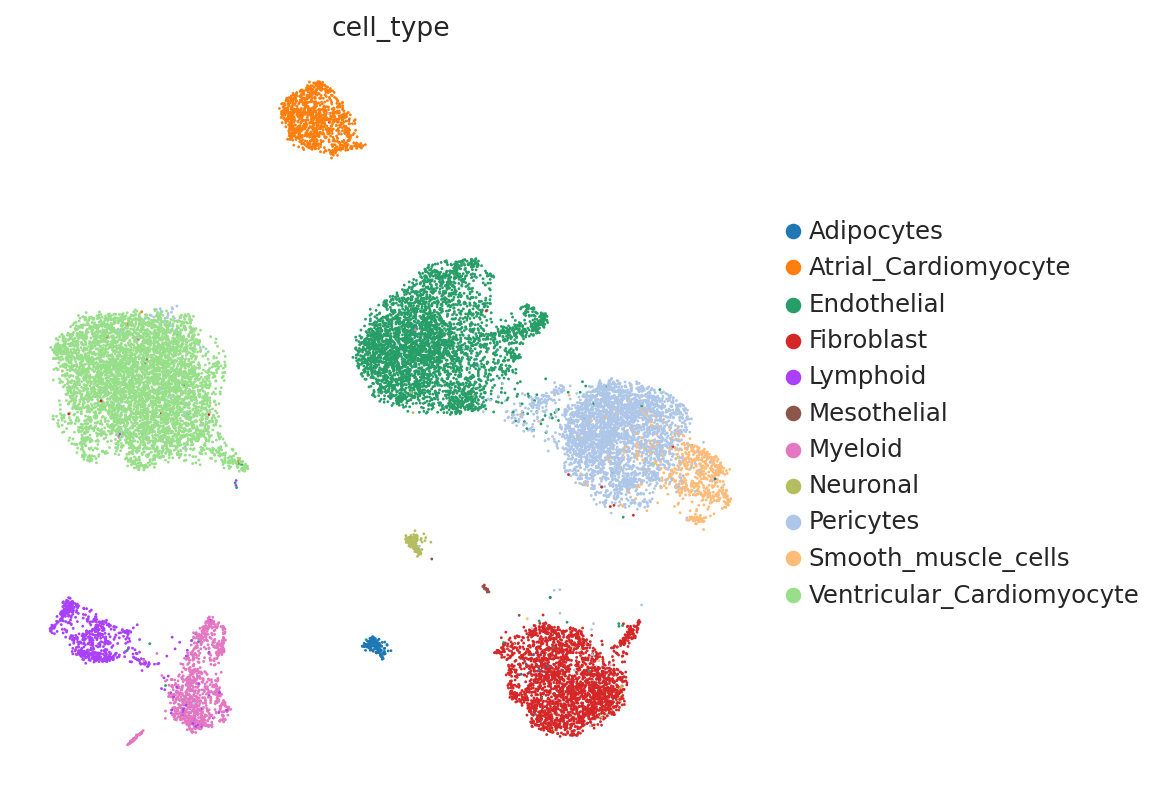

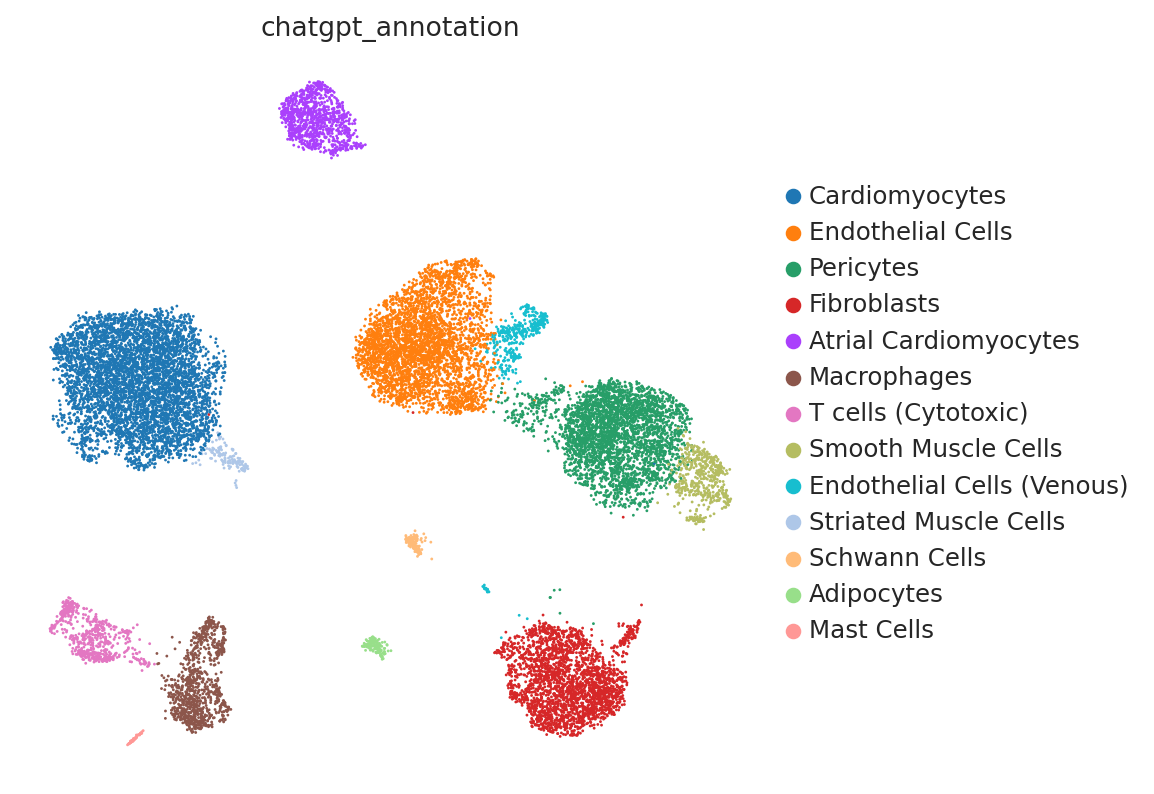

In [56]:
sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["chatgpt_annotation"],
    frameon=False,
)

Comparing the Chatgpt annotations with the annotations we already have, we see that certain cell types are labeled correctly while others are incorrect, but roughly in the right directions. Overall, we can use such tools as a starting point or to point us in the right direction if used correctly.

- Litviňuková, M., Talavera-López, C., Maatz, H., Reichart, D., Worth, C. L., Lindberg, E. L., ... & Teichmann, S. A. (2020). Cells of the adult human heart. Nature.
- Lopez, R., Regier, J., Cole, M. B.,  Jordan, M. I. & Yosef,  N. (2018). Deep generative modeling for single-cell transcriptomics. Nature Methods.